# Parte 2: Reconocimiento de objetos

Cargamos las imágenes

In [43]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage import exposure
from scipy.ndimage import rotate, shift

# Rutas de imágenes y máscaras
ruta_imagenes = r"C:\Users\norae\piva_enrique\Materiales1\objects\objects\images"
ruta_mascaras = r"C:\Users\norae\piva_enrique\Materiales1\objects\objects\masks"

# Diccionario de clases simplificado
clases = {
    'elephant': 0,
    'rhino': 1,
    'emu': 2,         # se etiquetará como "otros"
    'flamingo': 2     # también como "otros"
}

# Tamaño objetivo para redimensionar las imágenes
tamaño_objetivo = (200, 300)

# Función para cargar imágenes con su clase
def cargar_imagenes_objeto(ruta_base, clases, tamaño_objetivo):
    imagenes = []
    etiquetas = []

    for nombre_clase in os.listdir(ruta_base):
        if nombre_clase not in clases:
            continue

        etiqueta = clases[nombre_clase]
        ruta_clase = os.path.join(ruta_base, nombre_clase)
        nombres_archivos = sorted(os.listdir(ruta_clase))

        for nombre_archivo in nombres_archivos:
            ruta_imagen = os.path.join(ruta_clase, nombre_archivo)
            imagen = imread(ruta_imagen) / 255.0

            if imagen.ndim == 2:
                imagen = gray2rgb(imagen)

            imagen_redim = resize(imagen, tamaño_objetivo, anti_aliasing=True)
            imagenes.append(imagen_redim)
            etiquetas.append(etiqueta)

    return np.array(imagenes, dtype=np.float32), np.array(etiquetas)

# Función para cargar las máscaras
def cargar_mascaras(ruta_mascaras, clases, tamaño_objetivo):
    mascaras = []

    for nombre_clase in os.listdir(ruta_mascaras):
        if nombre_clase not in clases:
            continue

        ruta_clase = os.path.join(ruta_mascaras, nombre_clase)
        nombres_archivos = sorted(os.listdir(ruta_clase))

        for nombre_archivo in nombres_archivos:
            ruta_mascara = os.path.join(ruta_clase, nombre_archivo)
            imagen = imread(ruta_mascara) / 255.0

            imagen_redim = resize(imagen, tamaño_objetivo)
            mascara_binaria = (imagen_redim > 0.5).astype(np.uint8)
            mascaras.append(mascara_binaria)

    return np.array(mascaras)


In [44]:
# Función para aumentar el dataset 
def aumentar_dataset_manual(imagenes, mascaras, etiquetas, n_augmentaciones=2):
    imagenes_aug = []
    mascaras_aug = []
    etiquetas_aug = []

    for img, mask, label in zip(imagenes, mascaras, etiquetas):
        imagenes_aug.append(img)
        mascaras_aug.append(mask)
        etiquetas_aug.append(label)

        for _ in range(n_augmentaciones):
            img_aug = img.copy()
            mask_aug = mask.copy()

            # Flip horizontal
            if np.random.rand() > 0.5:
                img_aug = np.fliplr(img_aug)
                mask_aug = np.fliplr(mask_aug)

            # Flip vertical
            if np.random.rand() > 0.5:
                img_aug = np.flipud(img_aug)
                mask_aug = np.flipud(mask_aug)

            # Rotación aleatoria
            angle = np.random.uniform(-20, 20)
            img_aug = rotate(img_aug, angle, reshape=False, mode='reflect')
            mask_aug = rotate(mask_aug, angle, reshape=False, mode='nearest')

            # Desplazamiento aleatorio
            shift_x = np.random.uniform(-10, 10)
            shift_y = np.random.uniform(-10, 10)
            img_aug = shift(img_aug, shift=(shift_x, shift_y, 0), mode='reflect')
            mask_aug = shift(mask_aug, shift=(shift_x, shift_y), mode='nearest')

            # Ajuste de brillo/contraste
            if np.random.rand() > 0.5:
                gamma = np.random.uniform(0.8, 1.2)
                img_aug = exposure.rescale_intensity(img_aug, in_range='image', out_range=(0, 1))
                img_aug = exposure.adjust_gamma(img_aug, gamma=gamma)
                img_aug = np.clip(img_aug, 0, 1)

            imagenes_aug.append(img_aug)
            mascaras_aug.append((mask_aug > 0.5).astype(np.uint8))
            etiquetas_aug.append(label)

    return np.array(imagenes_aug), np.array(mascaras_aug), np.array(etiquetas_aug)

# Cargar datos filtrados
imagenes, etiquetas = cargar_imagenes_objeto(ruta_imagenes, clases, tamaño_objetivo)
mascaras = cargar_mascaras(ruta_mascaras, clases, tamaño_objetivo)

# Aumentar el dataset
imagenes_aug, mascaras_aug, etiquetas_aug = aumentar_dataset_manual(imagenes, mascaras, etiquetas, n_augmentaciones=2)

# Verificación
print(f"Número total de imágenes aumentadas: {imagenes_aug.shape[0]}")
indice = 43
print(f"Imagen {indice} - shape: {imagenes[indice].shape}, etiqueta: {etiquetas[indice]}")
print(f"Mascara {indice} - shape: {mascaras[indice].shape}, valores únicos: {np.unique(mascaras[indice])}")


Número total de imágenes aumentadas: 729
Imagen 43 - shape: (200, 300, 3), etiqueta: 0
Mascara 43 - shape: (200, 300), valores únicos: [0 1]


Vemos las imágenes 

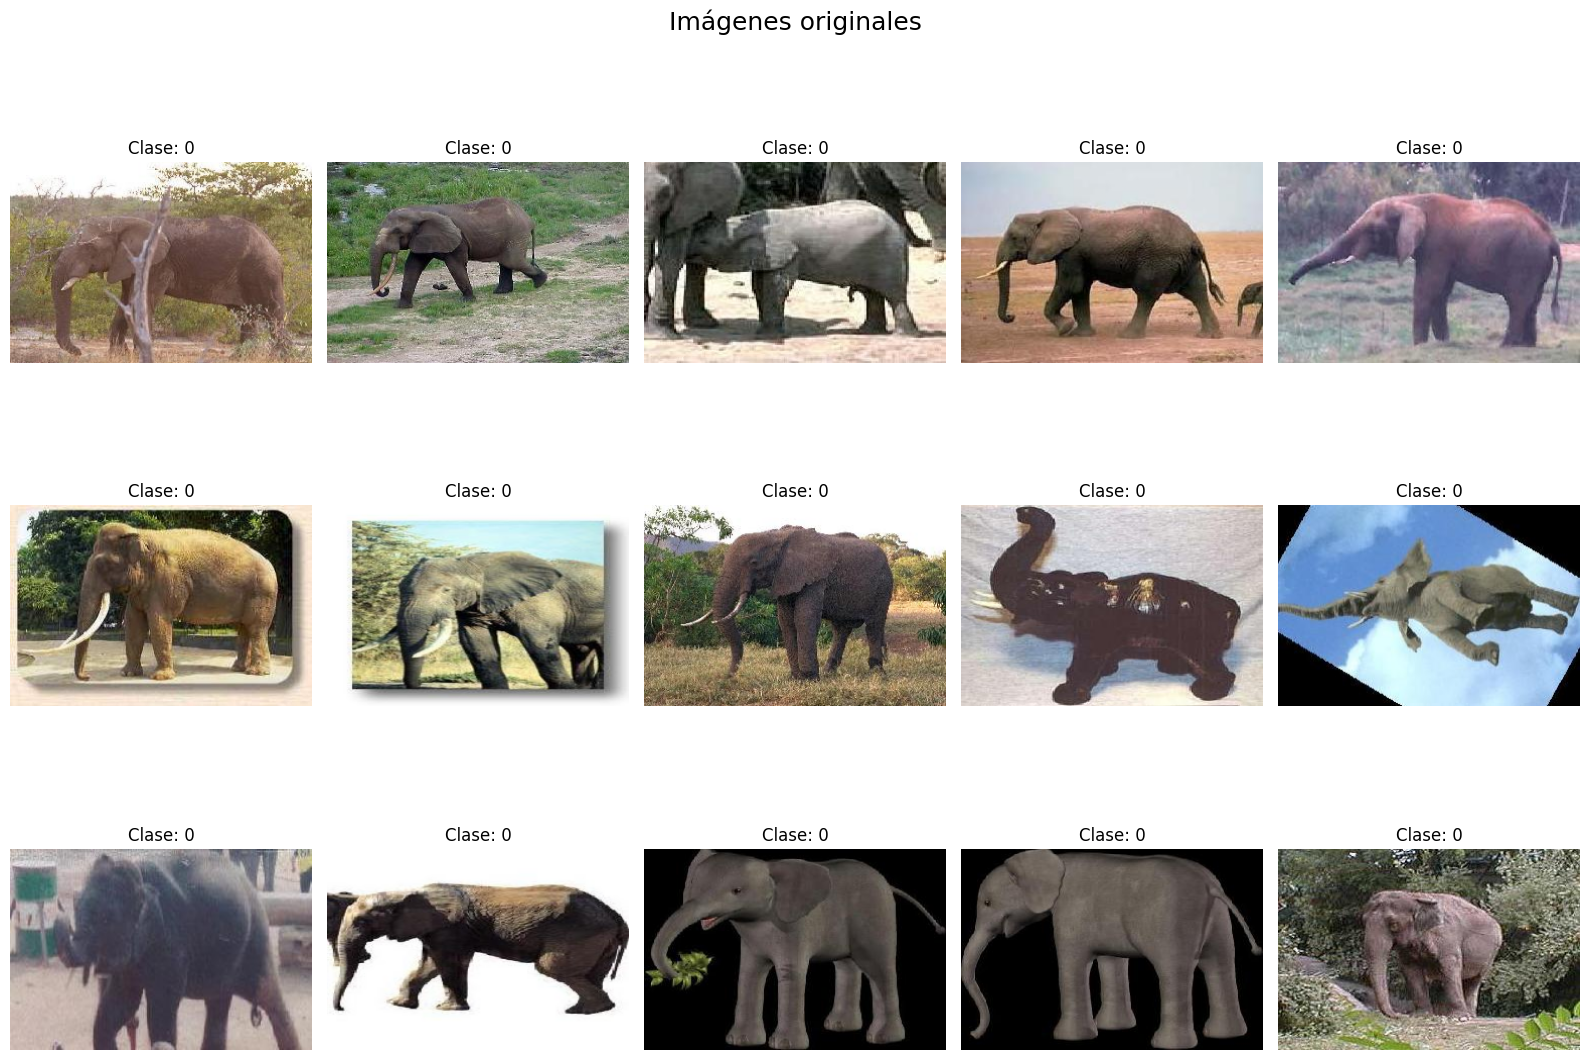

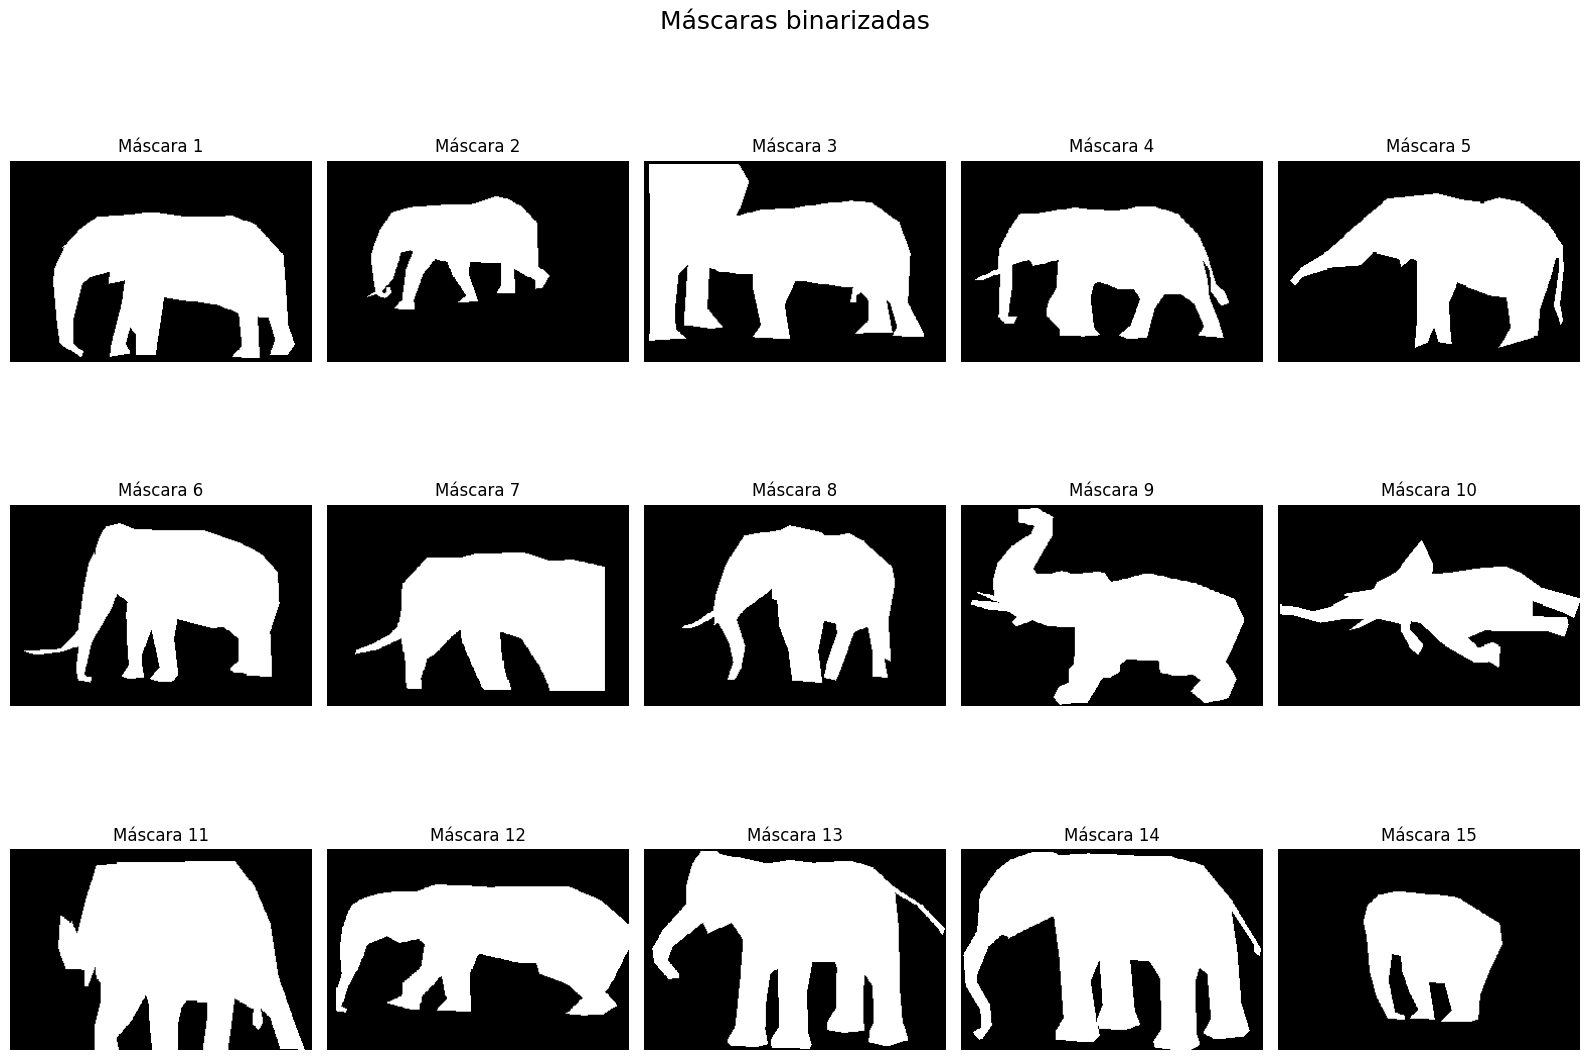

In [ ]:
import matplotlib.pyplot as plt

def mostrar_galeria(imagenes, titulos=None, filas=3, columnas=5, cmap=None, suptitulo=None):
    total = filas * columnas
    fig, axes = plt.subplots(filas, columnas, figsize=(16, 12))

    for i, ax in enumerate(axes.flat):
        if i < len(imagenes):
            imagen = imagenes[i]
            ax.imshow(imagen, cmap=cmap if imagen.ndim == 2 else None)
            if titulos:
                ax.set_title(str(titulos[i]))
            ax.axis('off')
        else:
            ax.axis('off')

    if suptitulo:
        plt.subplots_adjust(top=0.9)
        fig.suptitle(suptitulo, fontsize=18)

    plt.tight_layout()
    plt.show()

# Títulos 
titulos_animales = [f'Clase: {etiquetas[i]}' for i in range(len(imagenes))]
titulos_mascaras = [f'Máscara {i+1}' for i in range(len(mascaras))]

# Visualizar primeras 15 imágenes
mostrar_galeria(imagenes[:15], titulos_animales[:15], filas=3, columnas=5, suptitulo='Imágenes originales')

# Visualizar primeras 15 máscaras
mostrar_galeria(mascaras[:15], titulos_mascaras[:15], filas=3, columnas=5, cmap='gray', suptitulo='Máscaras binarizadas')


Extraemos las características del espacio RGB

In [ ]:
def obtener_medias_rgb(imagenes, mascaras):
    # Listas para almacenar las medias RGB de la figura (región de interés) y del fondo
    caracteristicas_figura = []
    caracteristicas_fondo = []

    # Recorrer todas las imágenes y sus respectivas máscaras
    for idx in range(len(imagenes)):
        img = imagenes[idx]       # Seleccionar imagen
        mask = mascaras[idx]      # Seleccionar máscara correspondiente

        # Separar los canales de color R, G y B de la imagen
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

        # Crear máscaras booleanas: True donde hay figura (valor 1), False en el resto
        indices_figura = mask == 1
        indices_fondo = mask == 0

        # Calcular la media de R, G, B en la figura
        # Si no hay píxeles de figura, se pone una media nula
        if not np.any(indices_figura):
            media_figura = [0.0, 0.0, 0.0]
        else:
            media_figura = [
                np.mean(r[indices_figura]),  # Media de canal R en figura
                np.mean(g[indices_figura]),  # Media de canal G en figura
                np.mean(b[indices_figura])   # Media de canal B en figura
            ]

        # Calcular la media de R, G, B en el fondo
        # Si no hay píxeles de fondo, se pone una media nula
        if not np.any(indices_fondo):
            media_fondo = [0.0, 0.0, 0.0]
        else:
            media_fondo = [
                np.mean(r[indices_fondo]),  # Media de canal R en fondo
                np.mean(g[indices_fondo]),  # Media de canal G en fondo
                np.mean(b[indices_fondo])   # Media de canal B en fondo
            ]

        # Guardar los vectores de medias para figura y fondo
        caracteristicas_figura.append(media_figura)
        caracteristicas_fondo.append(media_fondo)

    # Convertir las listas en arrays NumPy de tipo float32 y retornarlos
    return (
        np.array(caracteristicas_figura, dtype=np.float32),  # shape (n_imagenes, 3)
        np.array(caracteristicas_fondo, dtype=np.float32)    # shape (n_imagenes, 3)
    )


Extraemos el contorno de los animales

In [ ]:
from skimage.measure import label, regionprops
import numpy as np

def extraer_ratio_area_contorno(mascaras_binarias):
    ratios = []

    for mascara in mascaras_binarias:
        # Etiquetar regiones conectadas
        etiqueta = label(mascara) # Etiquetar las regiones conectadas en la máscara binaria

        # Extraer propiedades
        regiones = regionprops(etiqueta) # Extraer las propiedades de las regiones etiquetadas

        if len(regiones) > 0:
            # Tomamos la región de mayor área
            region_principal = max(regiones, key=lambda r: r.area)

            # Calcular el ratio entre el área real y el área del rectángulo delimitador
            area_real = region_principal.area
            minr, minc, maxr, maxc = region_principal.bbox
            alto = maxr - minr
            ancho = maxc - minc
            area_rect = alto * ancho

            proporcion = area_real / area_rect if area_rect > 0 else 0.0
            ratios.append(proporcion)
        else:
            ratios.append(0.0)

    return np.array(ratios, dtype=np.float32).reshape(-1, 1)



Extraemos texturas mediante orientación de gradiente

In [ ]:
from scipy.ndimage import gaussian_filter   
from skimage import color                   
import numpy as np                          

def generar_mapa_direcciones(angulo_grad, num_direcciones):
    # Calcula el ancho (en grados) de cada sector angular
    paso = 360 / num_direcciones

    # Define los centros de cada sector en el rango [-180, 180]
    sectores = np.linspace(-180, 180, num_direcciones)

    # Inicializa un mapa 3D (alto x ancho x num_direcciones) con ceros
    mapa_direcciones = np.zeros((*angulo_grad.shape, num_direcciones), dtype=int)

    # Para cada sector direccional, marca los píxeles que caen dentro del ángulo
    for idx, centro in enumerate(sectores):
        # Crea una máscara binaria donde el ángulo está dentro del sector
        dentro_sector = np.abs(angulo_grad - centro) < paso / 2

        # Almacena esa máscara en la capa correspondiente del mapa
        mapa_direcciones[:, :, idx] = dentro_sector.astype(int)

    # Devuelve el mapa direccional codificado como capas binarias
    return mapa_direcciones

def extraer_caracteristicas_textura(imagenes, mascaras):
    textura_total = []             # Lista para almacenar histogramas de cada imagen
    suavizado_sigma = 1           # Valor sigma para el filtro gaussiano

    # Itera sobre todas las imágenes y sus respectivas máscaras
    for img, mask in zip(imagenes, mascaras):
        # Convierte la imagen a escala de grises para análisis de gradiente
        img_gray = color.rgb2gray(img)

        # Aplica un suavizado Gaussiano para reducir el ruido antes del gradiente
        suavizada = gaussian_filter(img_gray, sigma=suavizado_sigma)

        # Calcula el gradiente en x (horizontal) y en y (vertical)
        grad_x = np.gradient(suavizada, axis=1)
        grad_y = np.gradient(suavizada, axis=0)

        # Calcula el ángulo de orientación del gradiente en grados
        orientacion = np.arctan2(grad_y, grad_x) * (180 / np.pi)

        # Convierte los ángulos en un mapa de direcciones discretas
        mapa = generar_mapa_direcciones(orientacion, 8)

        # Aplica la máscara binaria a cada canal direccional
        # Esto sirve para filtrar solo las figuras/animaless de interés
        direcciones_validas = mapa * mask[:, :, np.newaxis]

        # Suma los valores válidos por canal direccional → histograma 1D de 8 valores
        histograma = np.sum(direcciones_validas, axis=(0, 1))

        # Normaliza el histograma para que represente proporciones
        histograma_norm = histograma / np.sum(histograma)

        # Almacena el histograma normalizado como características de textura
        textura_total.append(histograma_norm)

    # Devuelve una matriz (n_imágenes x 8) con los histogramas de textura
    return np.array(textura_total)


In [ ]:
import numpy as np

# Extracción de características usando las imágenes aumentadas
caracteristicas_figura, caracteristicas_fondo = obtener_medias_rgb(imagenes_aug, mascaras_aug) # (n_imagenes, 3)
caracteristicas_contorno1 = extraer_ratio_area_contorno(mascaras_aug) # (n_imagenes, 1)
caracteristicas_textura = extraer_caracteristicas_textura(imagenes_aug, mascaras_aug) # (n_imagenes, 8)

# Construcción del conjunto de características y etiquetas
X = np.hstack([
    caracteristicas_figura,
    caracteristicas_fondo,
    caracteristicas_contorno1,
    caracteristicas_textura
]) # (n_imagenes, 3 + 3 + 1 + 8) cada fila es una imagen y cada columna una característica
y = etiquetas_aug
imgs = imagenes_aug
masks = mascaras_aug

# Verificación de dimensiones
print(" Dimensiones de las características:")
print(f"  RGB figura: {caracteristicas_figura.shape}")
print(f"  RGB fondo: {caracteristicas_fondo.shape}")
print(f"  Contorno (área): {caracteristicas_contorno1.shape}")
print(f"  Texturas direccionales: {caracteristicas_textura.shape}")
print(f"  Conjunto unificado: {X.shape}")


 Dimensiones de las características:
  RGB figura: (729, 3)
  RGB fondo: (729, 3)
  Contorno (área): (729, 1)
  Texturas direccionales: (729, 8)
  Conjunto unificado: (729, 15)


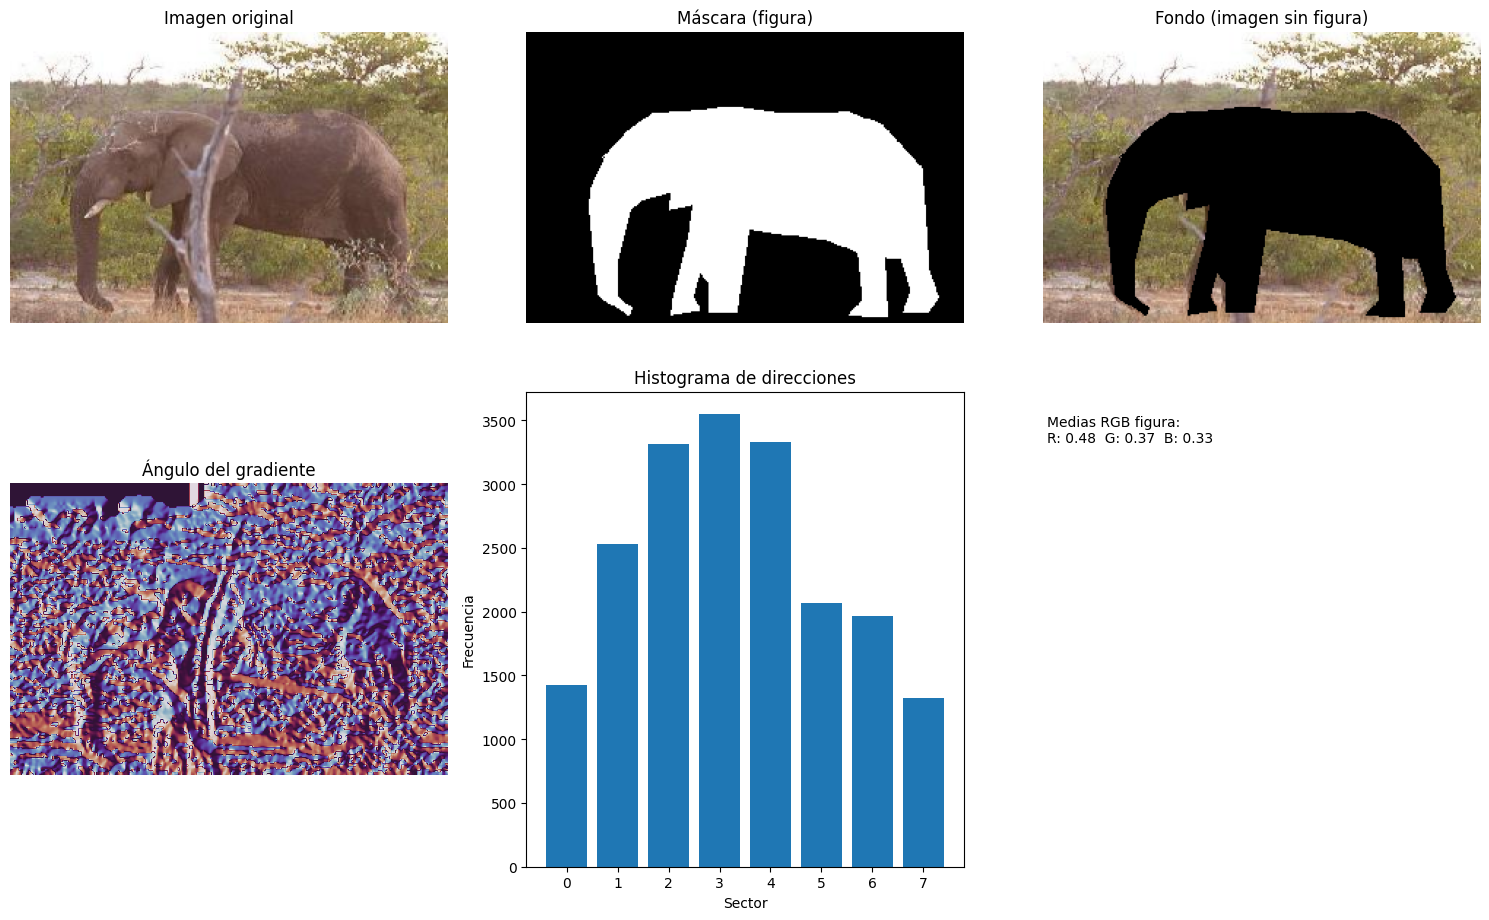

In [52]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.measure import label, regionprops, moments, moments_hu
from scipy.ndimage import gaussian_filter
import numpy as np

def visualizar_caracteristicas(imagen, mascara, mostrar_texto=True):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()
    
    # Imagen original
    axs[0].imshow(imagen)
    axs[0].set_title("Imagen original")
    axs[0].axis('off')
    
    # Máscara binaria (figura)
    axs[1].imshow(mascara, cmap='gray')
    axs[1].set_title("Máscara (figura)")
    axs[1].axis('off')
    
    # Fondo enmascarado
    fondo = imagen.copy()
    fondo[mascara == 1] = 0
    axs[2].imshow(fondo)
    axs[2].set_title("Fondo (imagen sin figura)")
    axs[2].axis('off')

    # Ángulo del gradiente
    imagen_gris = color.rgb2gray(imagen)
    suavizada = gaussian_filter(imagen_gris, sigma=1)
    dx = np.gradient(suavizada, axis=1)
    dy = np.gradient(suavizada, axis=0)
    angulo = np.arctan2(dy, dx) * (180 / np.pi)
    axs[3].imshow(angulo, cmap='twilight', vmin=-180, vmax=180)
    axs[3].set_title("Ángulo del gradiente")
    axs[3].axis('off')
    
    # Histograma de direcciones
    direcciones = generar_mapa_direcciones(angulo, 8)
    direcciones_mascaradas = direcciones * mascara[:, :, np.newaxis]
    frecuencias = np.sum(direcciones_mascaradas, axis=(0, 1))
    axs[4].bar(range(8), frecuencias)
    axs[4].set_title("Histograma de direcciones")
    axs[4].set_xlabel("Sector")
    axs[4].set_ylabel("Frecuencia")

    # Datos numéricos
    if mostrar_texto:
        # Medias RGB figura
        rgb_figura = imagen[mascara == 1]
        media_rgb = np.mean(rgb_figura, axis=0)

        # Momentos de Hu con skimage
        etiqueta = label(mascara)
        regiones = regionprops(etiqueta)

        texto = "Medias RGB figura:\n" + \
                f"R: {media_rgb[0]:.2f}  G: {media_rgb[1]:.2f}  B: {media_rgb[2]:.2f}\n\n"


        axs[5].axis('off')
        axs[5].text(0.01, 0.95, texto, fontsize=10, verticalalignment='top')
    else:
        axs[5].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
visualizar_caracteristicas(imagenes[0], mascaras[0])


Definimos el modelo y entrenamos con todas las característicaas extraídas

Dividimos los datos en entrenamiento y test

In [53]:
from sklearn.model_selection import train_test_split

# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test, imgs_train, imgs_test, masks_train, masks_test = train_test_split(
    X, y, imgs, masks, test_size=0.2, random_state=42, stratify=y
)

# Información sobre la división
print("\nDivisión del dataset:")
print("────────────────────────────")
print("Conjunto de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  imgs_train: {imgs_train.shape}")
print(f"  masks_train: {masks_train.shape}")

print("\nConjunto de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  imgs_test: {imgs_test.shape}")
print(f"  masks_test: {masks_test.shape}")


División del dataset:
────────────────────────────
Conjunto de entrenamiento:
  X_train: (583, 15)
  y_train: (583,)
  imgs_train: (583, 200, 300, 3)
  masks_train: (583, 200, 300)

Conjunto de prueba:
  X_test: (146, 15)
  y_test: (146,)
  imgs_test: (146, 200, 300, 3)
  masks_test: (146, 200, 300)


Vamos a probar distintas combinaciones de hiperparámetros para ver cuáles son mejores para nuestro entrenamiento

Se comparan mediante el f1-score ya que busca equilibrio entre precision y recall, solo será alto si ambos son altos.

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Reemplazar valores no finitos por ceros, algunas operaciones pueden generar NaN o inf
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0) 
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Escalado estándar de los datos de entrada
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train) 
X_test_scaled = normalizer.transform(X_test) 

# Conversión explícita de etiquetas a enteros y luego a one-hot encoding (float32)
y_train = y_train.astype("int32")
y_test = y_test.astype("int32")

Y_train_onehot = to_categorical(y_train, num_classes=3).astype("float32")
Y_test_onehot = to_categorical(y_test, num_classes=3).astype("float32")

# Definición de los hiperparámetros a probar
lr_options = [0.001, 0.01, 0.1]
dropout_values = [0.4, 0.6, 0.8]
batch_options = [4, 8, 16]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam

# Número de clases de salida (según el one-hot encoding)
n_classes = Y_train_onehot.shape[1]

# Lista para almacenar los resultados de evaluación del modelo
eval_metrics = []

# Bucle de búsqueda de hiperparámetros
for lr in lr_options:
    for drop in dropout_values:
        for batch in batch_options:

            # Definición de la arquitectura de la red neuronal
            network = Sequential([
                Input(shape=(X_train_scaled.shape[1],)),
                Dense(256, activation='relu'),
                BatchNormalization(),
                Dropout(drop),

                Dense(128, activation='tanh'),
                Dropout(drop),

                Dense(64, activation='relu'),
                Dropout(drop),

                Dense(32, activation='relu'),
                Dropout(drop),

                Dense(16, activation='relu'),
                Dense(n_classes, activation='softmax')  # Capa de salida con softmax para clasificación multiclase
            ])

            # Compilación del modelo
            network.compile(
                optimizer=Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall', 'AUC']
            )

            # Entrenamiento del modelo 
            network.fit(X_train_scaled, Y_train_onehot, epochs=50, batch_size=batch, verbose=1)

            # Predicción sobre el conjunto de test
            preds = network.predict(X_test_scaled)
            pred_labels = np.argmax(preds, axis=1)
            true_labels = np.argmax(Y_test_onehot, axis=1)

            # Cálculo de las métricas de evaluación
            acc = accuracy_score(true_labels, pred_labels)
            prec = precision_score(true_labels, pred_labels, average='macro', zero_division=0.0)
            rec = recall_score(true_labels, pred_labels, average='macro', zero_division=0.0)
            f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0.0)

            # Almacenamiento de las métricas junto con los hiperparámetros usados
            eval_metrics.append({
                'learning_rate': lr,
                'dropout_rate': drop,
                'batch_size': batch,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1
            })

# Selección de la mejor configuración según el F1-score
optimal_config = max(eval_metrics, key=lambda res: res['f1'])

print("Mejor combinación de hiperparámetros:")
print(optimal_config)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.5121 - Precision: 0.3715 - Recall: 0.1919 - accuracy: 0.3538 - loss: 1.2963
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6900 - Precision: 0.6262 - Recall: 0.3423 - accuracy: 0.4889 - loss: 1.0122
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7756 - Precision: 0.7009 - Recall: 0.4040 - accuracy: 0.5893 - loss: 0.9036
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7935 - Precision: 0.7043 - Recall: 0.4510 - accuracy: 0.6052 - loss: 0.8381
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7893 - Precision: 0.6839 - Recall: 0.4344 - accuracy: 0.5984 - loss: 0.8475
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8055 - Precision: 0.7031 - Recall: 0.4407 - accuracy: 0.6147 - loss: 0.8395
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8088 - Precision: 0.6982 - Recall: 0.4565 - accuracy: 0.5962 - loss: 0.7999
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1

Escogemos los mejores parámetros y entrenamos modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Parámetros óptimos encontrados previamente
dropout_rate = 0.4
learning_rate = 0.001
batch_size = 16

input_dim = X_train_scaled.shape[1]
n_classes = Y_train_onehot.shape[1]

# Definición del modelo
best_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(128, activation='tanh'),
    Dropout(dropout_rate),

    Dense(64, activation='relu'),
    Dropout(dropout_rate),

    Dense(32, activation='relu'),
    Dropout(dropout_rate),

    Dense(16, activation='relu'),
    Dense(n_classes, activation='softmax') # Salida: clasificación multiclase con softmax, vector de probabilidad
])

# Compilación del modelo
best_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Entrenamiento con conjunto de validación
history = best_model.fit(
    X_train_scaled,
    Y_train_onehot,
    epochs=100,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - Precision: 0.3090 - Recall: 0.1513 - accuracy: 0.3255 - loss: 1.2461 - val_Precision: 1.0000 - val_Recall: 0.1301 - val_accuracy: 0.5000 - val_loss: 0.9917
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6243 - Recall: 0.3434 - accuracy: 0.5097 - loss: 0.9603 - val_Precision: 0.9189 - val_Recall: 0.2329 - val_accuracy: 0.6164 - val_loss: 0.8791
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7623 - Recall: 0.4047 - accuracy: 0.6008 - loss: 0.8322 - val_Precision: 0.9333 - val_Recall: 0.2877 - val_accuracy: 0.6644 - val_loss: 0.8002
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7303 - Recall: 0.4607 - accuracy: 0.6031 - loss: 0.7765 - val_Precision: 0.9362 - val_Recall: 0.3014 - val_accuracy: 0.6781 - val_loss: 0.7590
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7834 - Recall: 0.4947 - accuracy: 0.6447 - loss: 0.7335 - val_Precision: 0.9333 - val_Recall: 0.3

Predecimos para dicho modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.686     0.615     0.649        39
           1      0.535     0.657     0.590        35
           2      0.941     0.889     0.914        72

    accuracy                          0.760       146
   macro avg      0.721     0.720     0.718       146
weighted avg      0.776     0.760     0.766       146



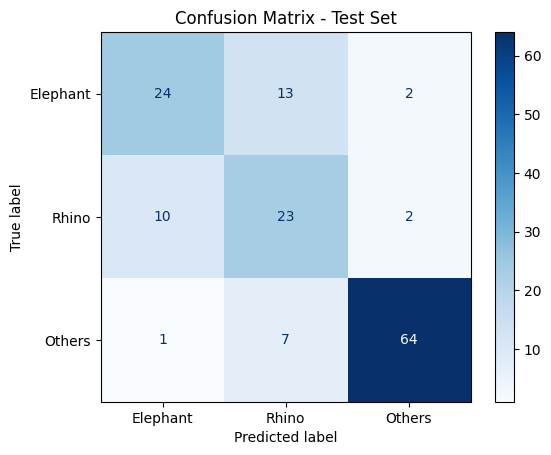

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predicciones
y_test_pred_probs = best_model.predict(X_test_scaled) # Probabilidades de clase
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1) # Etiquetas predichas
y_test_true_labels = np.argmax(Y_test_onehot, axis=1) # Etiquetas verdaderas

# Reporte
print("Classification Report:")
print(classification_report(y_test_true_labels, y_test_pred_labels, digits=3))

# Matriz de confusión
class_names = ['Elephant', 'Rhino', 'Others']
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()


Visualizamos predicciones en el test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11641828..1.0890203].


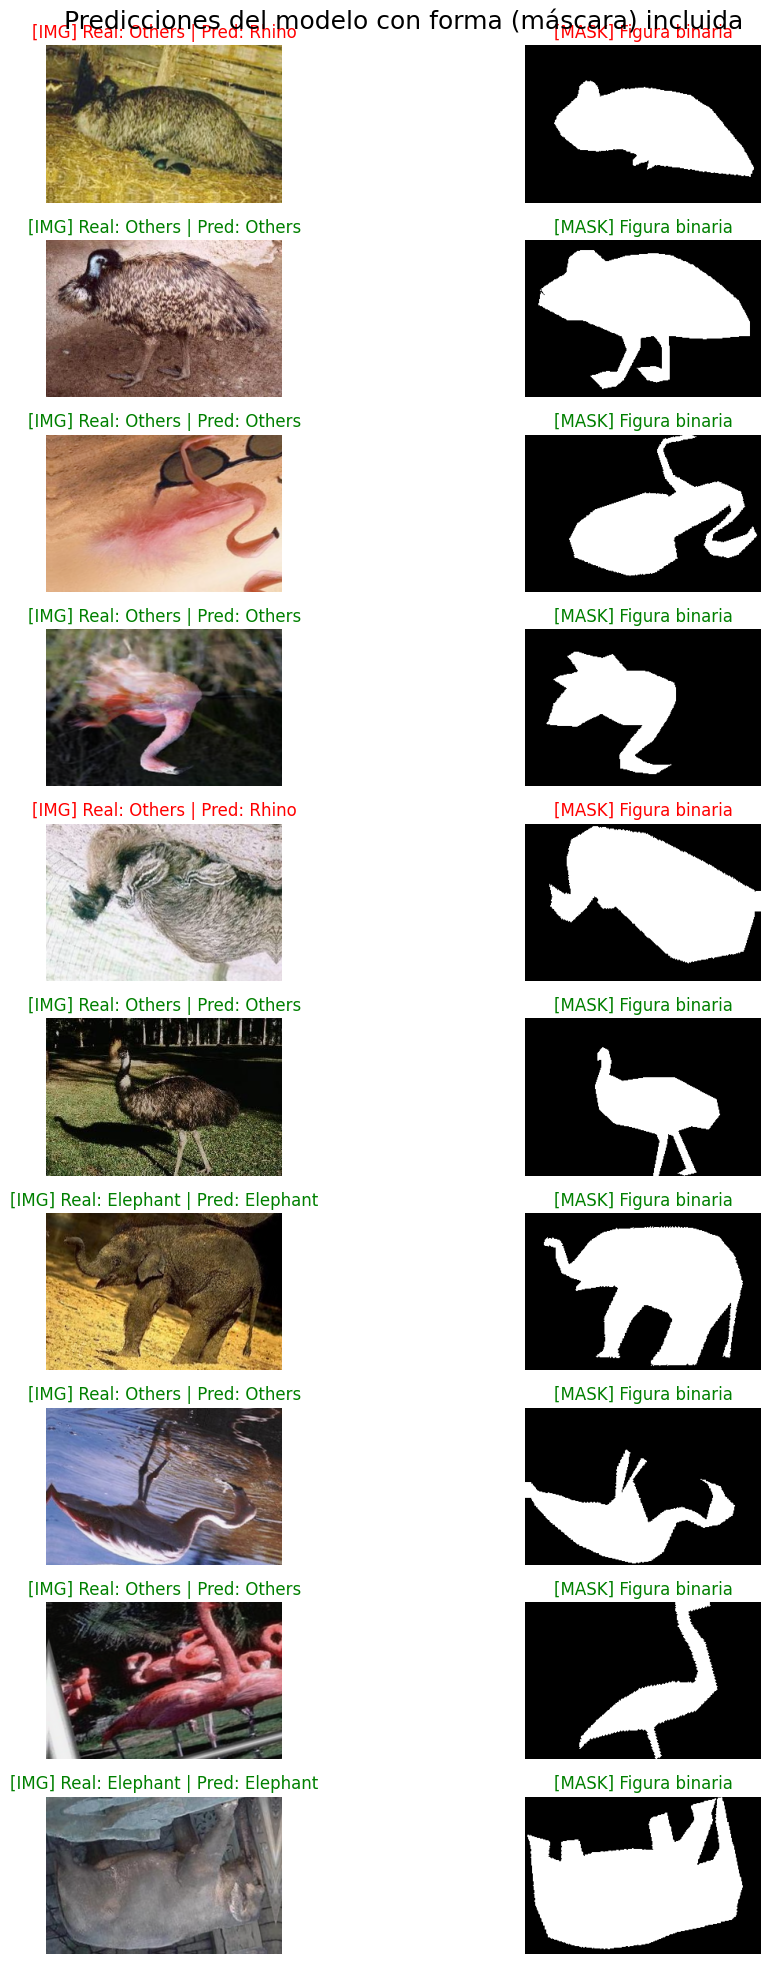

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Número de ejemplos a mostrar
num_examples = 10
indices = np.random.choice(len(X_test_scaled), num_examples, replace=False)

# Nombres de clases
class_names = ['Elephant', 'Rhino', 'Others']

plt.figure(figsize=(12, 6 * num_examples // 3))

for i, idx in enumerate(indices):
    img = imgs_test[idx]
    mask = masks_test[idx]  
    true_label = y_test[idx]
    pred_label = y_test_pred_labels[idx]

    color = 'green' if true_label == pred_label else 'red'

    # Imagen original
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"[IMG] Real: {class_names[true_label]} | Pred: {class_names[pred_label]}", color=color)

    # Máscara binaria
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title(f"[MASK] Figura binaria", color=color)

plt.suptitle("Predicciones del modelo con forma (máscara) incluida", fontsize=18)
plt.tight_layout()
plt.show()


Ahora, para ver si hay diferencias, entrenamos el modelo solo con los canales RGB y el contorno

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Solo RGB figura (3), RGB fondo (3), contorno área (1) = 7 características
X_rgb_contour = X[:, :7]

X_train_rc, X_test_rc, y_train_rc, y_test_rc, imgs_train_rc, imgs_test_rc, masks_train_rc, masks_test_rc = train_test_split(
    X_rgb_contour, etiquetas_aug, imagenes_aug, mascaras_aug, test_size=0.2, random_state=42
)

# Escalado
scaler_rc = StandardScaler()
X_train_rc_scaled = scaler_rc.fit_transform(X_train_rc)
X_test_rc_scaled = scaler_rc.transform(X_test_rc)

# One-hot encoding
y_train_rc = y_train_rc.astype("int32")
y_test_rc = y_test_rc.astype("int32")

Y_train_rc_onehot = to_categorical(y_train_rc, num_classes=4).astype("float32")
Y_test_rc_onehot = to_categorical(y_test_rc, num_classes=4).astype("float32")

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam

model_rgb_contour = Sequential([
    Input(shape=(7,)),  # Solo 7 características ahora
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='tanh'),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.4),

    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

model_rgb_contour.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

history_rc = model_rgb_contour.fit(
    X_train_rc_scaled,
    Y_train_rc_onehot,
    validation_data=(X_test_rc_scaled, Y_test_rc_onehot),
    epochs=100,
    batch_size=16,
    verbose=1
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - AUC: 0.5404 - Precision: 0.3289 - Recall: 0.1348 - accuracy: 0.3484 - loss: 1.6884 - val_AUC: 0.9020 - val_Precision: 1.0000 - val_Recall: 0.0274 - val_accuracy: 0.6575 - val_loss: 1.1638
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8334 - Precision: 0.7109 - Recall: 0.3905 - accuracy: 0.6038 - loss: 0.9896 - val_AUC: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.2877 - val_accuracy: 0.6575 - val_loss: 0.9294
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8618 - Precision: 0.6718 - Recall: 0.4973 - accuracy: 0.6103 - loss: 0.8734 - val_AUC: 0.9346 - val_Precision: 1.0000 - val_Recall: 0.4041 - val_accuracy: 0.6986 - val_loss: 0.7918
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8711 - Precision: 0.6632 - Recall: 0.4816 - accuracy: 0.5918 - loss: 0.8621 - val_AUC: 0.9332 - val_Precision: 1.0000 - val_Recall: 0.4521 - val_accuracy: 0.7055 - val_loss: 0.7054
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Clasification Report (solo RGB + contorno):
              precision    recall  f1-score   support

           0     0.7500    0.9231    0.8276        39
           1     0.7368    0.5385    0.6222        26
           2     0.9747    0.9506    0.9625        81

    accuracy                         0.8699       146
   macro avg     0.8205    0.8041    0.8041       146
weighted avg     0.8723    0.8699    0.8659       146



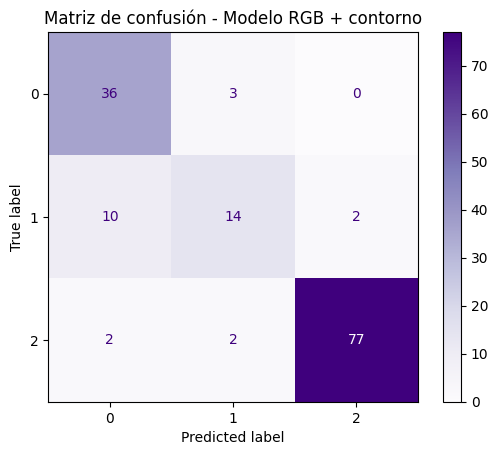

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predicciones del modelo
y_pred_probs_rc = model_rgb_contour.predict(X_test_rc_scaled)
y_pred_labels_rc = np.argmax(y_pred_probs_rc, axis=1)
y_true_labels_rc = np.argmax(Y_test_rc_onehot, axis=1)

# Reporte de clasificación
print("Clasification Report (solo RGB + contorno):")
print(classification_report(y_true_labels_rc, y_pred_labels_rc, digits=4))

# Matriz de confusión
cm_rc = confusion_matrix(y_true_labels_rc, y_pred_labels_rc)
disp_rc = ConfusionMatrixDisplay(confusion_matrix=cm_rc)
disp_rc.plot(cmap='Purples')
plt.title("Matriz de confusión - Modelo RGB + contorno")
plt.grid(False)
plt.show()


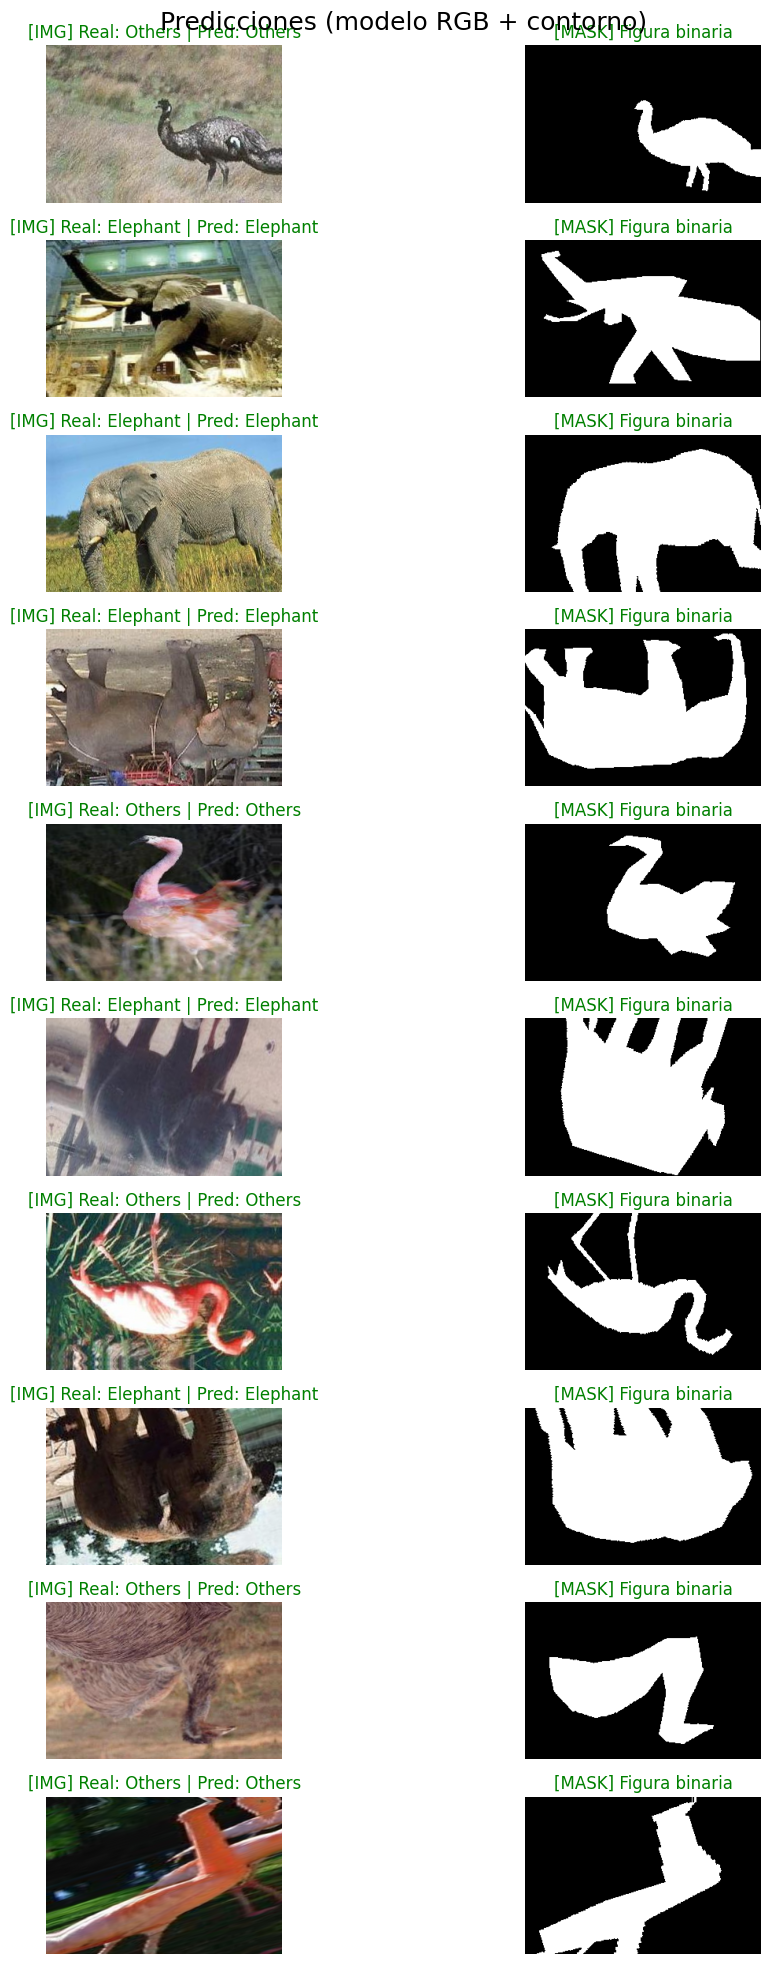

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Número de ejemplos a mostrar
num_examples = 10

# Selección aleatoria de índices del conjunto de test
indices_rc = np.random.choice(len(X_test_rc), num_examples, replace=False)

# Nombres de las clases (deben coincidir con tu codificación)
class_names = ['Elephant', 'Rhino', 'Others']

# Figura general
plt.figure(figsize=(12, 6 * num_examples // 3))

for i, idx in enumerate(indices_rc):
    img = imgs_test_rc[idx]                    
    mask = masks_test_rc[idx]                  # Máscara correspondiente
    true_label = int(y_test_rc[idx])           # Etiqueta real como entero
    pred_label = int(y_pred_labels_rc[idx])    # Etiqueta predicha

    color = 'green' if true_label == pred_label else 'red'  # Color del texto según acierto

    # Evitar problemas con valores fuera de rango [0,1]
    img_clipped = np.clip(img, 0.0, 1.0)

    # Mostrar imagen original
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(img_clipped)
    plt.axis('off')
    plt.title(f"[IMG] Real: {class_names[true_label]} | Pred: {class_names[pred_label]}", color=color)

    # Mostrar máscara binaria
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("[MASK] Figura binaria", color=color)

plt.suptitle("Predicciones (modelo RGB + contorno)", fontsize=18)
plt.tight_layout()
plt.show()


Comparación de métricas

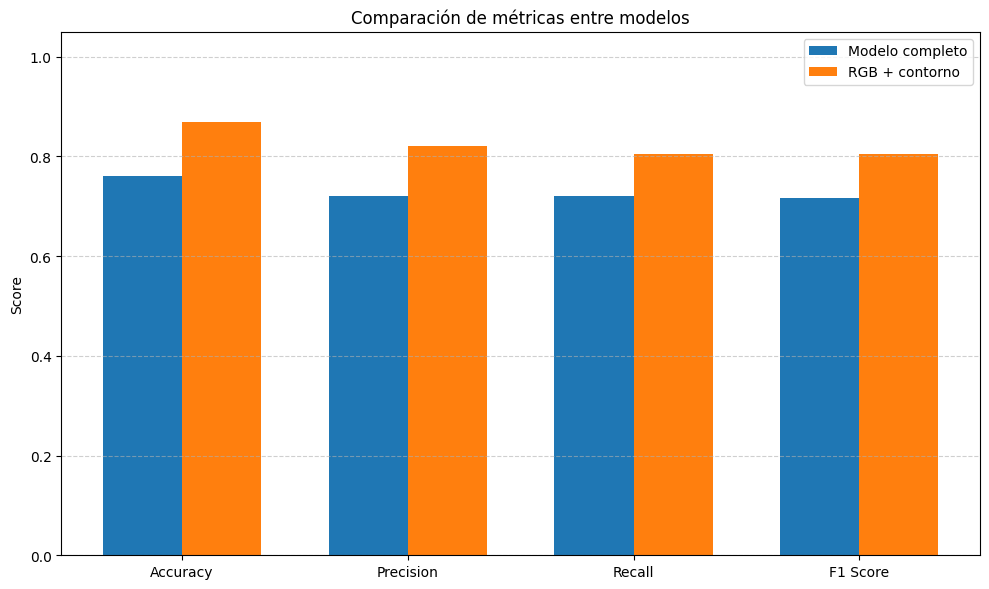

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas del modelo completo
metrics_full = {
    "Accuracy": accuracy_score(y_test_true_labels, y_test_pred_labels),
    "Precision": precision_score(y_test_true_labels, y_test_pred_labels, average='macro', zero_division=0.0),
    "Recall": recall_score(y_test_true_labels, y_test_pred_labels, average='macro'),
    "F1 Score": f1_score(y_test_true_labels, y_test_pred_labels, average='macro'),
}

# Métricas del modelo RGB + contorno
metrics_rgbc = {
    "Accuracy": accuracy_score(y_true_labels_rc, y_pred_labels_rc),
    "Precision": precision_score(y_true_labels_rc, y_pred_labels_rc, average='macro', zero_division=0.0),
    "Recall": recall_score(y_true_labels_rc, y_pred_labels_rc, average='macro'),
    "F1 Score": f1_score(y_true_labels_rc, y_pred_labels_rc, average='macro'),
}

# Preparar gráfico
metric_names = list(metrics_full.keys())
val_full = [metrics_full[m] for m in metric_names]
val_rgbc = [metrics_rgbc[m] for m in metric_names]

x = np.arange(len(metric_names))
width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, val_full, width, label='Modelo completo')
plt.bar(x + width/2, val_rgbc, width, label='RGB + contorno')

plt.xticks(x, metric_names)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Comparación de métricas entre modelos')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
